# Real Time Loan Eligibility 
The Client wants to automate loan eligibility in real time. The solution will determine "Loan_Status" based on key features. Current solution is to have an expert look over the information and determine eligibility. The solution cuts down on workload of experts and saves labor costs. The solution will also be fed new data overtime, so we can label this as an __Online Supervised Classification Task.__ Given that this is Loan Eligibility, Pre Approving loans incorrectly will harm bottom line. We are shooting for a high precision and, high specificity in order to reduce labor cost in low risk cases, otherwise an expert will still be needed to review these cases.

__Assumptions:__
> * ApplicantIncome, CoapplicantIncome, LoanAmount, LoanAmountTerm, CreditHistory and, Education will be among the most important features.
> * ApplicantIncome & CoapplicantIncome may be combinable into a single feature.
> * There exists an Income level where the model will auto approve all loans.

### Imports and Loading Data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../Data/HomeLoanApproval/loan_sanction_train.csv')
df.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Splitting Data
Income & Coapplicant Income is a major factor in determining the result. Given our small dataset we will seek to do a stratified split over a random split. However grouping would be better if it were something broad as raw data will have more outliers.

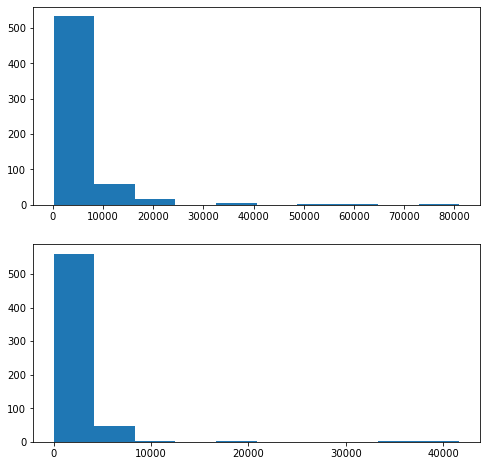

In [5]:
fig, axs = plt.subplots(2,1, figsize=(8,8))

axs[0].hist(df['ApplicantIncome'])
axs[1].hist(df['CoapplicantIncome'])
plt.show()

In [6]:
income_ = (df.ApplicantIncome + df.CoapplicantIncome)
df['IncomeCategory'] = pd.cut(income_, bins=[0, 8000, 16000, 24000, 40000, np.inf], labels=[1,2,3,4,5])
from sklearn.model_selection import train_test_split
strat_train, strat_test = train_test_split(
    df, test_size=0.2, stratify=df['IncomeCategory'], random_state=7)
print(strat_train['IncomeCategory'].value_counts()/len(strat_train) - df['IncomeCategory'].value_counts()/len(df))
print(strat_test['IncomeCategory'].value_counts()/len(strat_test) - df['IncomeCategory'].value_counts()/len(df))

1   -0.000902
2    0.000066
3    0.000421
4    0.000411
5    0.000003
Name: IncomeCategory, dtype: float64
1    0.003602
2   -0.000265
3   -0.001682
4   -0.001642
5   -0.000013
Name: IncomeCategory, dtype: float64


In [7]:
for set_ in (strat_train, strat_test):
    set_.drop('IncomeCategory', axis=1, inplace=True)

In [8]:
# Set columns to all follow same spelling rules
std_col_names = ['LoanID', 'Gender', 'Married', 'Dependents', 'Education', 'SelfEmployed', 
                 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'LoanAmountTerm', 
                 'CreditHistory', 'PropertyArea', 'LoanStatus']
col_names_dict = dict(zip(list(strat_train.columns),std_col_names))
strat_train.columns = strat_train.columns.map(col_names_dict)
strat_test.columns = strat_test.columns.map(col_names_dict)

In [9]:
X_train, y_train = strat_train.iloc[:, :-1], strat_train.iloc[:, -1]

### Reformatting Data

Several of the data columns are unusable in their current format. 
> ColumnID = Type. - > New Designated Type. Notes
* Loan_ID = String. All unique, no repeats. String.
* Gender = String - > Bool. Male or female. Missing 13 values.
* Married = String - > Bool. Missing 3 values.
* Dependents = String - > Category. Missing 15 values.
* Education = String - > Bool.
* Self Employed = String - > Bool
* ApplicatnIncome = int64
* CoapplicantIncome = float64
* LoanAmount = float64. Missing 24 values. _Can these even be approved?_
* Loan_Amount_Term = float64. Missing 14 values.
* Credit_History = float64 - > Category. Missing 50 values.
* PropertyArea = Object - > Category.

In [10]:
bool_list = ['Gender', 'Married', 'Education', 'SelfEmployed']
cat_list = ['PropertyArea', 'Dependents', 'CreditHistory']
num_list = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'LoanAmountTerm']

## Missing Values

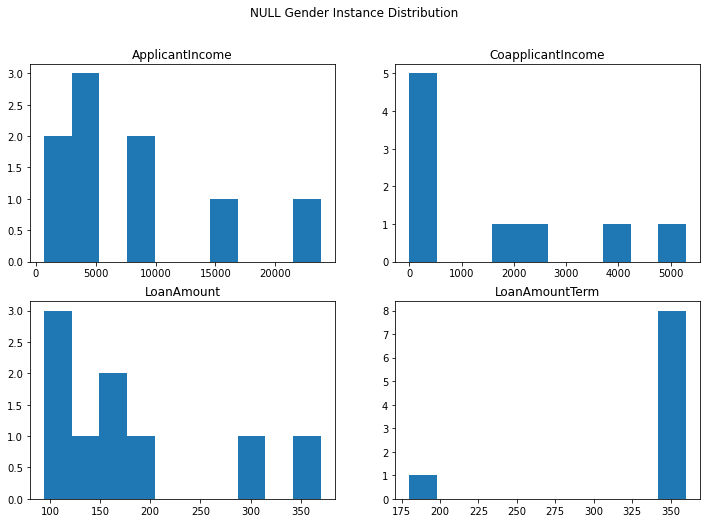

In [11]:
mask = X_train['Gender'].isnull()
fig, axs = plt.subplots(2,2, figsize=(12,8))
axs = axs.flatten()
for idx, c in enumerate(num_list):
    axs[idx].hist(X_train[mask][c])
    axs[idx].set_title(c)
plt.suptitle('NULL Gender Instance Distribution')
plt.show()

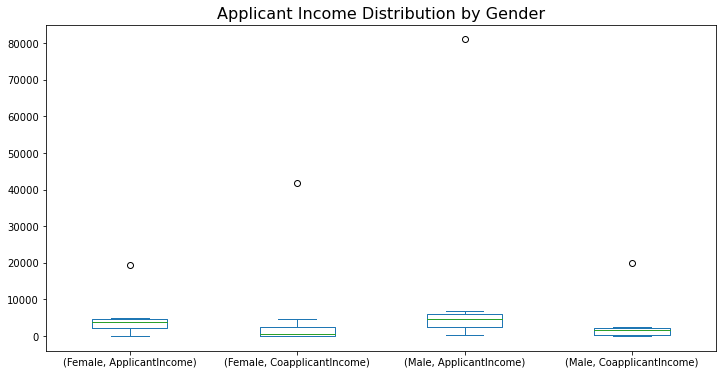

In [12]:
group = X_train.groupby('Gender')
df_ = group.describe()
df_[['ApplicantIncome', 'CoapplicantIncome']].T.unstack(level=0).plot(kind='box', figsize=(12,6))
plt.title('Applicant Income Distribution by Gender', fontsize=16)
plt.show()

## Numericals
<b> LoanAmount & LoanAmountTerm</b> are both very important features.

In [13]:
print(f'Unique Valeues of LoanAmount: {X_train["LoanAmount"].nunique()}')
print(f'Unique Valeues of LoanAmountTerm: {X_train["LoanAmountTerm"].nunique()}')

Unique Valeues of LoanAmount: 183
Unique Valeues of LoanAmountTerm: 9


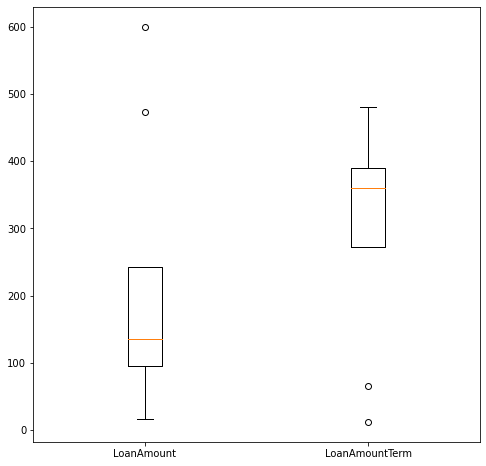

In [14]:
plt.figure(figsize=(8,8))
plt.boxplot(X_train[['LoanAmount', 'LoanAmountTerm']].describe(), labels=['LoanAmount', 'LoanAmountTerm'])
plt.show()

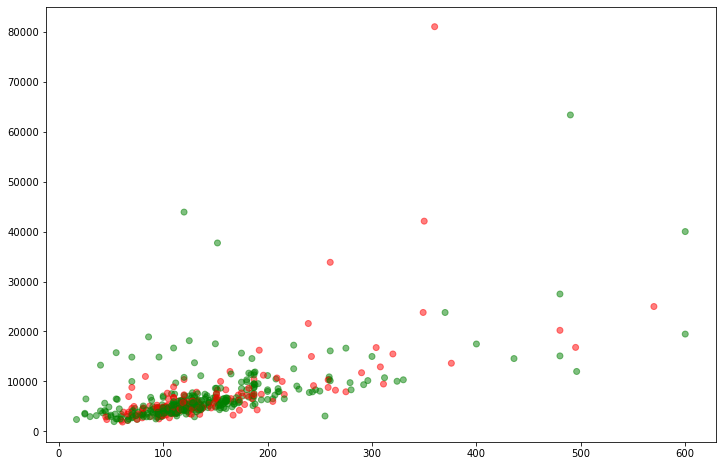

In [15]:
X_train['TotalIncome'] = X_train['ApplicantIncome']+X_train['CoapplicantIncome']
d = {'N':'Red', 'Y':'Green'}
plt.figure(figsize=(12,8))
plt.scatter(X_train['LoanAmount'], X_train['TotalIncome'], c=y_train.map(d), alpha=.5)
plt.show()

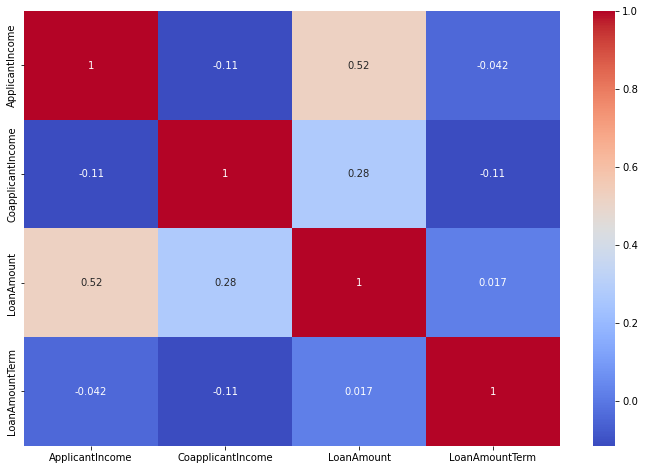

In [16]:
corr_matrix = X_train[num_list].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

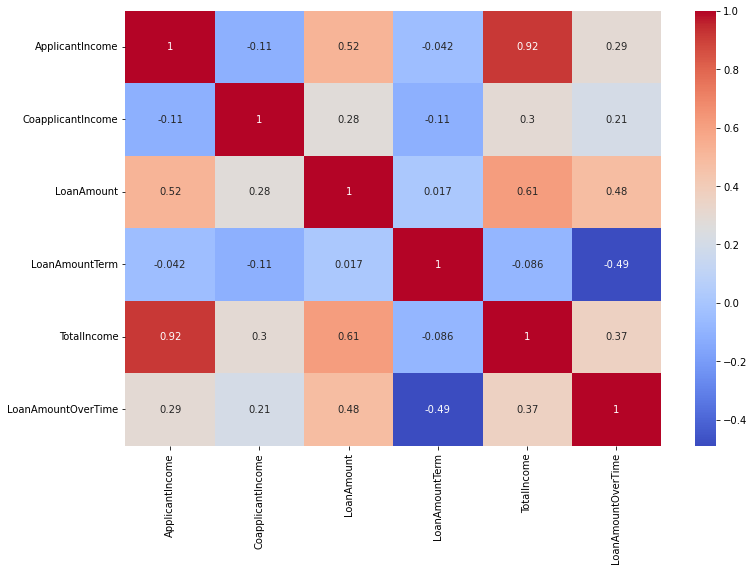

In [17]:
X_train['TotalIncome'] = X_train['ApplicantIncome'] + X_train['CoapplicantIncome']
X_train['LoanAmountOverTime'] = X_train['LoanAmount']/X_train['LoanAmountTerm']
l_ = num_list+['TotalIncome', 'LoanAmountOverTime']
corr_matrix=X_train[l_].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

<b>Takeaway:</b> 

Within this dataset;
* There doesn't appear to be a point where loans are automatically approved by income.
* We also see a trend of rejects which carry about the same income parameter as approval.
* There exists a very strong correlation of income to loan amount.

With Feature Creation;
* TotalIncome:LoanAmount has a stronger correlation than Applicant:LoanAmount, but isn't definitively better
* LoanAmountOverTime doesn't seem like a better alternative to the seperate features of LoanAmount and LoanAmountTerm



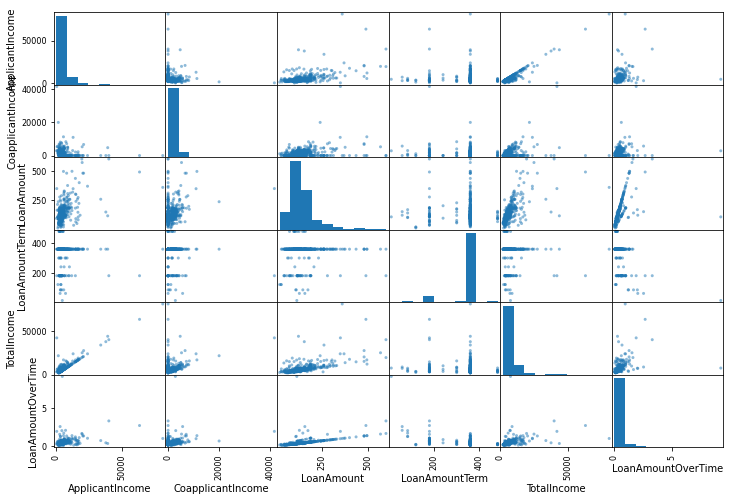

In [18]:
from pandas.plotting import scatter_matrix
scatter_matrix(X_train[l_], figsize=(12,8))
plt.show()

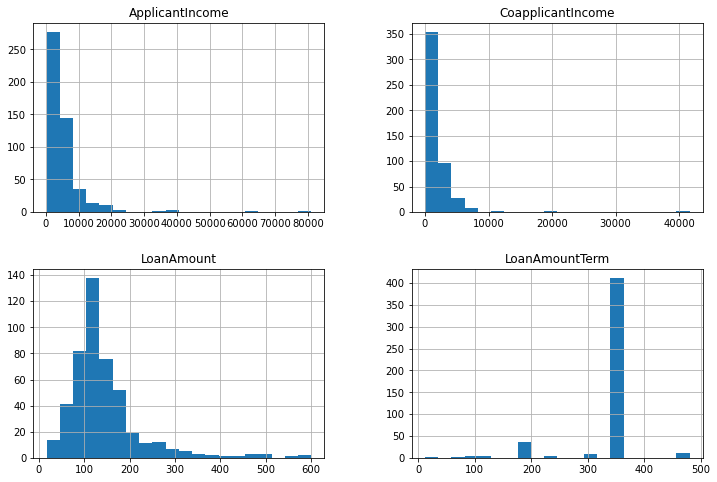

In [19]:
X_train[num_list].hist(bins=20, figsize=(12,8))
plt.show()

## Scaling

We have a heavy right tail, so we have to adjust the dataset before scaling. Let's experiment with best possible distributions.

In [20]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train[num_list])
X = imputer.transform(X_train[num_list])

In [21]:
from sklearn.preprocessing import StandardScaler
sc_ = StandardScaler()
sc_.fit(X)
X_ = sc_.transform(X)

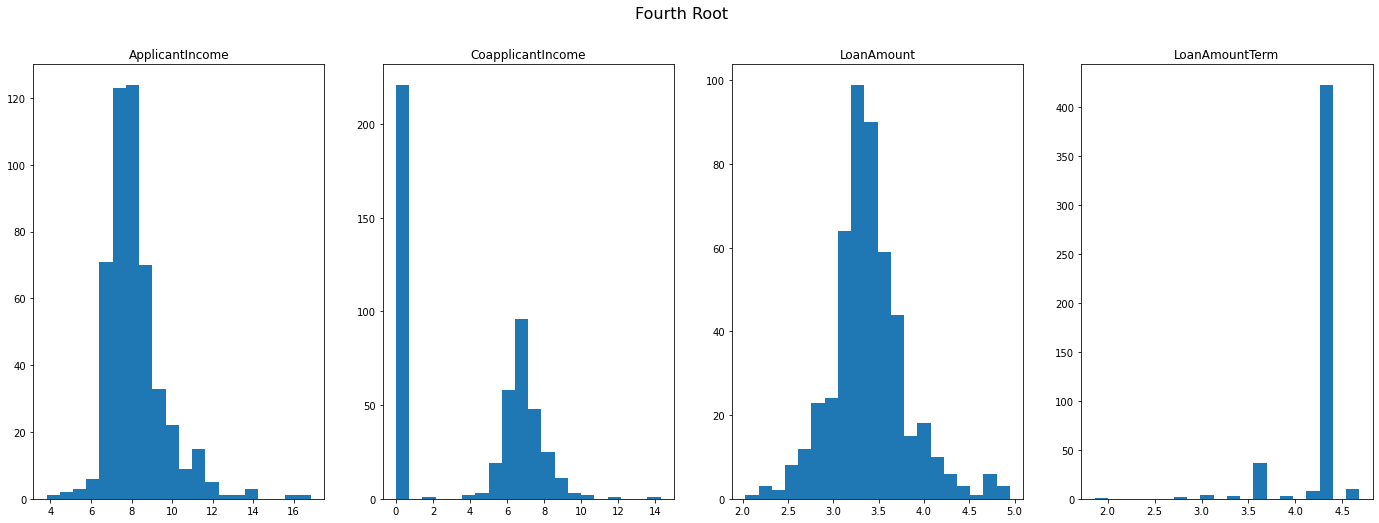

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(24,8))
axs = axs.flatten()
for idx in range(X.shape[1]):
    axs[idx].hist(X[:,idx]**0.25, bins=20)
    axs[idx].set_title(imputer.get_feature_names_out()[idx])
plt.suptitle('Fourth Root', fontsize=16)
plt.show()

C:\Users\Charles\AppData\Local\Temp\ipykernel_13472\1222438615.py:3: RuntimeWarning: divide by zero encountered in log
  X_log = np.where(X>0, np.log(X), 0)


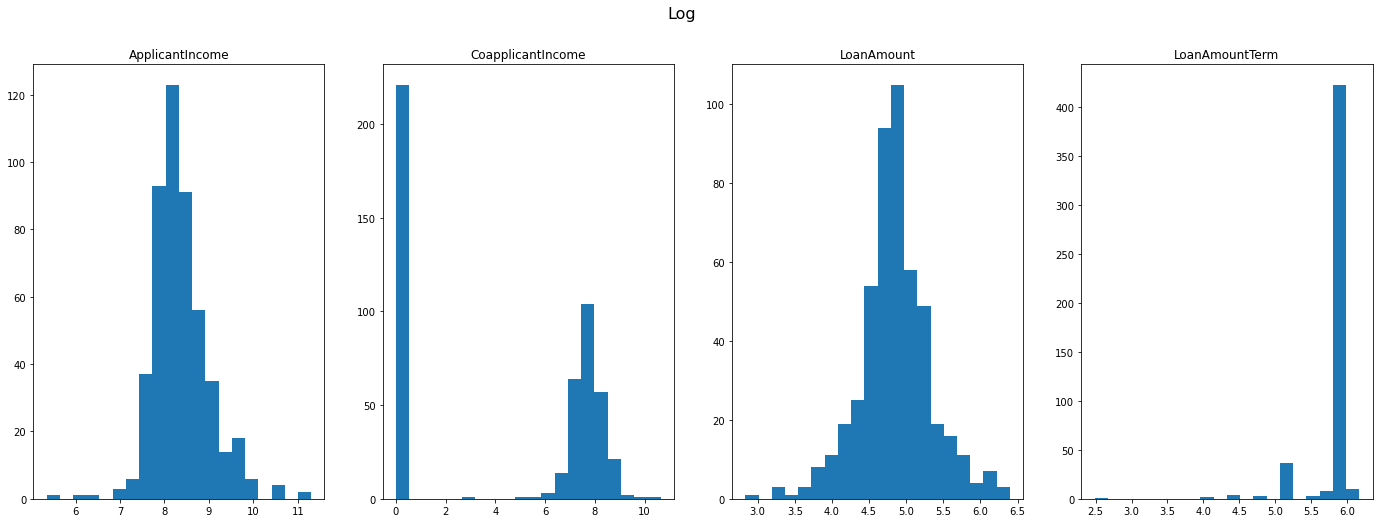

In [23]:
fig, axs = plt.subplots(1,4, figsize=(24,8))
axs = axs.flatten()
X_log = np.where(X>0, np.log(X), 0)
for idx in range(X.shape[1]):
    axs[idx].hist(X_log[:, idx], bins=20)
    axs[idx].set_title(imputer.get_feature_names_out()[idx])
plt.suptitle('Log', fontsize=16)
plt.show()

In [24]:
def num_pretransform(arr):
    arr[:, 0] = np.where(X[:, 0]>0, np.log(X[:, 0]), 0)
    arr[:, 1] = arr[:, 1]**0.25
    arr[:, 2] = arr[:, 2]**0.25
    return arr

# Pipeline

In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
def col_ratio(X):
    return X[:, [0]]/X[:, [1]]
def ratio_name(function_transformer, feature_names_in):
    return ['ratio']
def add(X):
    return X[:, [0]]+X[:, [1]]
def fourth_root(X):
    return X**0.25

# Smaller Pipelines
class TotalIncomeFeature(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None, drop=False):
        X.loc[:, 'TotalIncome'] = X['ApplicantIncome'] + X['CoapplicantIncome']
        X.loc[:, 'LoanAmountOverTime'] = X['LoanAmount'] / X['LoanAmountTerm']
        if drop==True:
            X = X.drop(['ApplicantIncome', 'LoanAmount', 'LoanAmountTerm'], axis=1)
        return X

feature_creation_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(add, feature_names_out=ratio_name)),
    ('standard', StandardScaler())
])
ratio_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(col_ratio, feature_names_out = ratio_name)),
    ('standard', StandardScaler())
])
pretrans_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(fourth_root, feature_names_out='one-to-one')),
    ('standard', StandardScaler())
])
log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False, handle_unknown='ignore'))
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler())
# Column Transformer
preprocessing = ColumnTransformer([
    # ('TotalIncome', feature_creation_pipeline, ['ApplicantIncome', 'CoapplicantIncome']),
    # ('AmountOverTime', ratio_pipeline, ['LoanAmount', 'LoanAmountTerm']),
    ('Adjust_distribution', pretrans_pipeline, ['LoanAmount', 'CoapplicantIncome']),
    ('log', log_pipeline, ['ApplicantIncome', 'TotalIncome']),
    ('cat', cat_pipeline, cat_list+bool_list),
    ('num', num_pipeline, num_list),
], remainder='drop')


## Helper Functions

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
def mdl_vs_dummy(mdl, X, y, cv, scoring):
    dummy_clf = DummyClassifier()
    dummy_scores = cross_val_score(dummy_clf, X, y, cv=cv, scoring=scoring)
    mdl_scores = cross_val_score(mdl, X, y, cv=cv, scoring=scoring)
    print(f'FPR - Model: {[1 - i for i in mdl_scores]}')
    print(f'FPR - Dummy: {[1 - i for i in dummy_scores]}')
    print(f'Model\'s best improvement over dummy: {mdl_scores.max() - dummy_scores.max()}')

In [63]:
from sklearn.metrics import recall_score, make_scorer
from sklearn.dummy import DummyClassifier
def false_pos_rate(mdl, X, y, cv):
    specificity = make_scorer(recall_score, pos_label=0)
    dummy_clf = DummyClassifier()
    dummy_scores = cross_val_score(dummy_clf, X, y, cv=cv, scoring=specificity)
    mdl_scores = cross_val_score(mdl, X, y, cv=cv, scoring=specificity)
    print(f'FPR - Model: {[1 - i for i in mdl_scores]}')
    print(f'FPR - Dummy: {[1 - i for i in dummy_scores]}')

In [30]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve

def threshold_eval(mdl, X, y, cv, method='decision_function', threshold=0.90):
    y_scores = cross_val_predict(mdl, X, y, cv=cv, method=method)
    if method=='predict_proba':
        y_scores=y_scores[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    
    # Threshold eval
    idx_for_p = (precisions >=threshold).argmax()
    threshold_for_p = thresholds[idx_for_p]
    recall = recall_score(y_train_prep.ravel(), (y_scores >= threshold_for_p))
    
    
    print(f'{threshold*100}% Precision marker: {threshold_for_p}')
    print(f'Recall at {threshold*100}% Precision: {recall}')
    # Prepping ROC
    fpr, tpr, roc_thresholds = roc_curve(y, y_scores)
    idx_for_threshold_roc = (roc_thresholds <= threshold_for_p).argmax()
    tpr_90, fpr_90 = tpr[idx_for_threshold_roc], fpr[idx_for_threshold_roc]
    
    # Plotting PRC, Precision/Recall &, ROC
    fig, axs = plt.subplots(3, 1, figsize=(24,24))
    # Plottin PRC
    axs[0].plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    axs[0].plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    axs[0].set_xlabel('Threshold', fontsize=16)
    # Plotting Precision/Recall
    axs[1].plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')
    axs[1].set_xlabel('Recall', fontsize=16)
    axs[1].set_ylabel('Precision', fontsize=16)
    # Plotting ROC
    axs[2].plot(fpr, tpr, linewidth=2, label='ROC curve')
    axs[2].plot([0,1],[0,1], 'k:', label='Random clf curve')
    axs[2].plot([fpr_90], [tpr_90], 'ko', label=f'Threshold for {threshold*100}% precision')
    axs[2].set_xlabel('False Positive Rate', fontsize=16)
    axs[2].set_ylabel('True Positive Rate', fontsize=16)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    plt.show()

In [99]:
from sklearn.metrics import confusion_matrix
def plot_cm(y_train, y_pred):
    cm = confusion_matrix(y_train, y_pred)
    plt.figure(figsize=(12,8))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.show()

## Prep X & Y

In [31]:
X_train_prep = X_train.drop(['LoanID', 'TotalIncome', 'LoanAmountOverTime'], axis=1)

In [32]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_prep = lb.fit_transform(y_train)
y_train_prep = y_train_prep.ravel()

# First Model Fittings

## SGD

In [89]:
from sklearn.linear_model import SGDClassifier
sample_weight = {0:1, 1:1}
sgd_clf = make_pipeline(TotalIncomeFeature(),
preprocessing, SGDClassifier(class_weight=sample_weight, random_state=7))
sgd_clf.fit(X_train_prep, y_train_prep)

Pipeline(steps=[('totalincomefeature', TotalIncomeFeature()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('Adjust_distribution',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('function',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function fourth_root at 0x0000025A13568040>)),
                                                                  ('standard',
                                                                   StandardScaler())]),
                                                  ['LoanAmou...
                                                  ['PropertyArea', 'Dependents',
                                                   'CreditHistory', 'Gender',
                                                   'Married', 'Education',
                                                   'SelfEmployed']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'LoanAmountTerm'])])),
                ('sgdclassifier',
                 SGDClassifier(class_weight={0: 1, 1: 1}, random_state=7))])

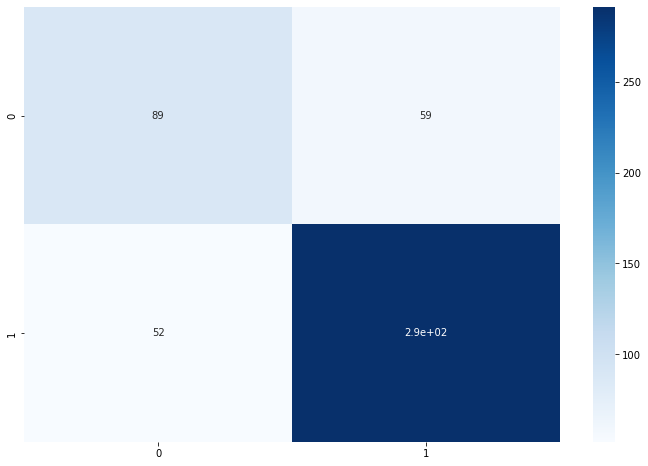

In [100]:
pred = sgd_clf.predict(X_train_prep)
plot_cm(y_train_prep, pred)

In [122]:
false_pos_rate(sgd_clf, X_train_prep, y_train_prep, cv=5)

FPR - Model: [0.5666666666666667, 0.5, 0.6, 0.48275862068965514, 0.48275862068965514]
FPR - Dummy: [1.0, 1.0, 1.0, 1.0, 1.0]


80.0% Precision marker: -0.41960358658287333
Recall at 80.0% Precision: 0.880466472303207


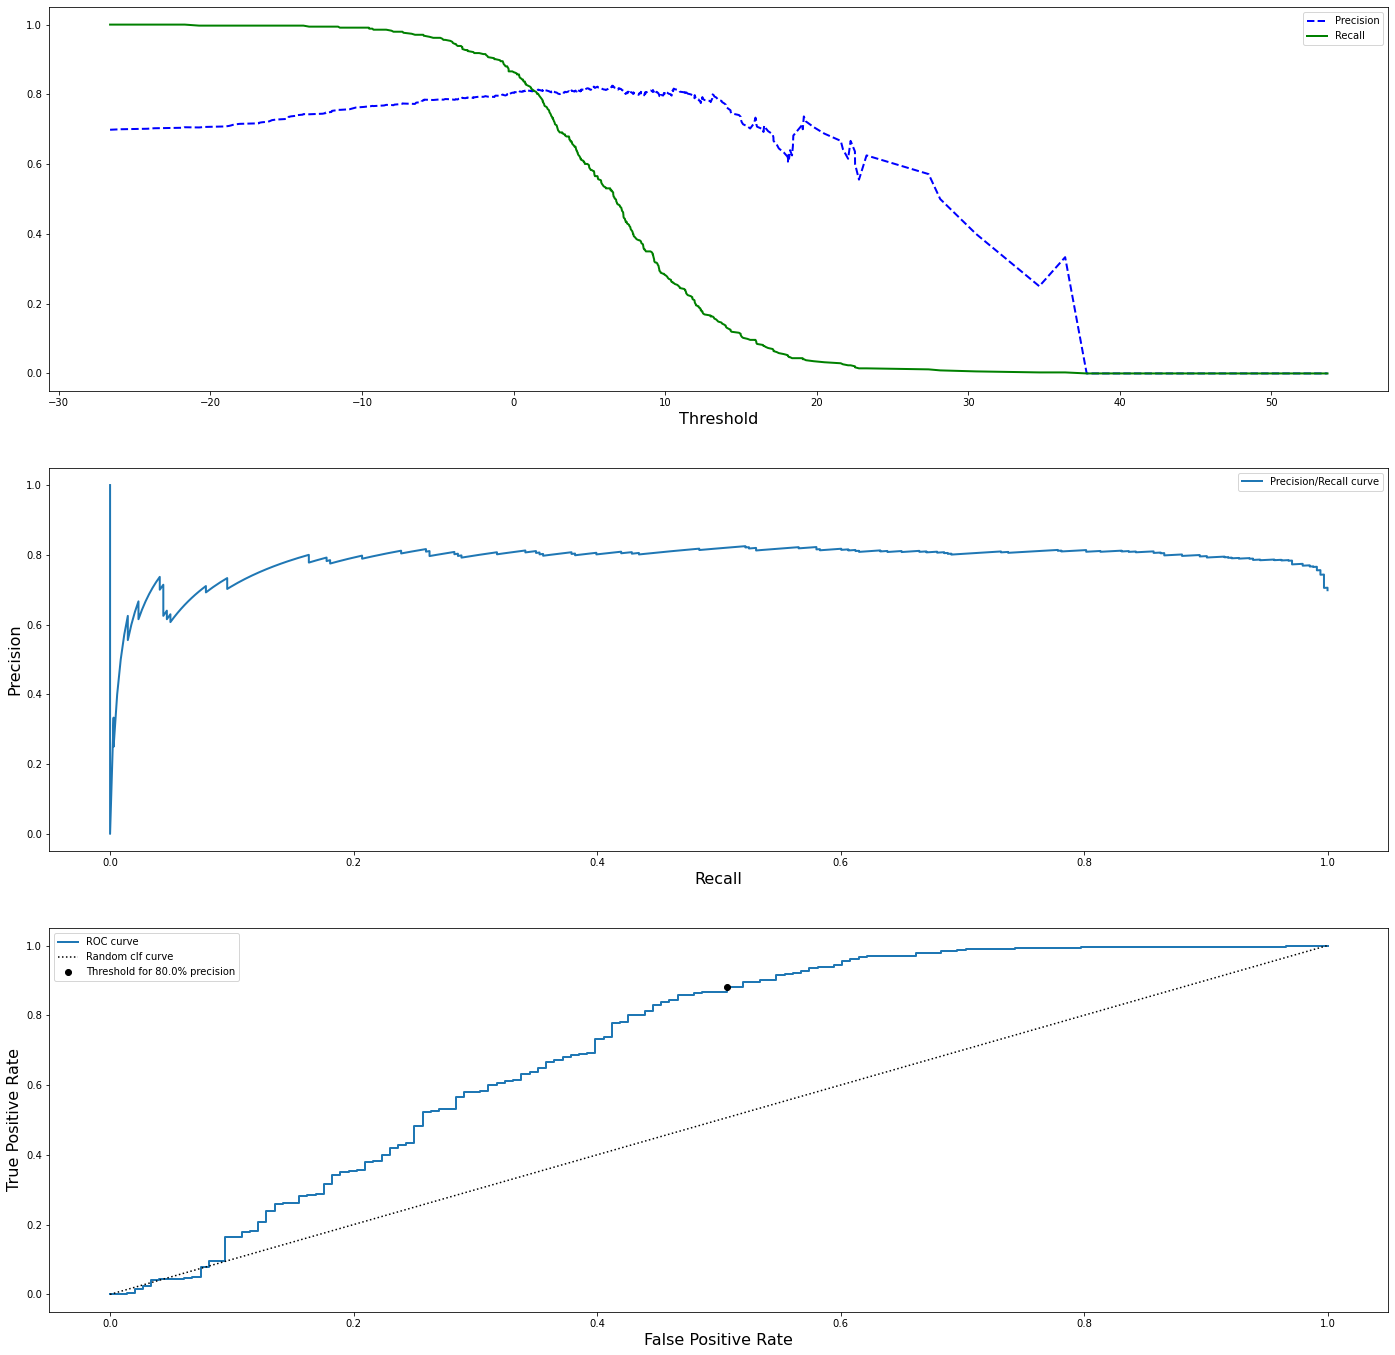

In [121]:
threshold_eval(sgd_clf, X_train_prep, y_train_prep, cv=3, threshold=0.8)

## KNeighbors

In [123]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = make_pipeline(TotalIncomeFeature(), preprocessing, KNeighborsClassifier())
knn_clf.fit(X_train_prep, y_train_prep)

Pipeline(steps=[('totalincomefeature', TotalIncomeFeature()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('Adjust_distribution',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('function',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function fourth_root at 0x0000025A13568040>)),
                                                                  ('standard',
                                                                   StandardScaler())]),
                                                  ['LoanAmou...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['PropertyArea', 'Dependents',
                                                   'CreditHistory', 'Gender',
                                                   'Married', 'Education',
                                                   'SelfEmployed']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'LoanAmountTerm'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

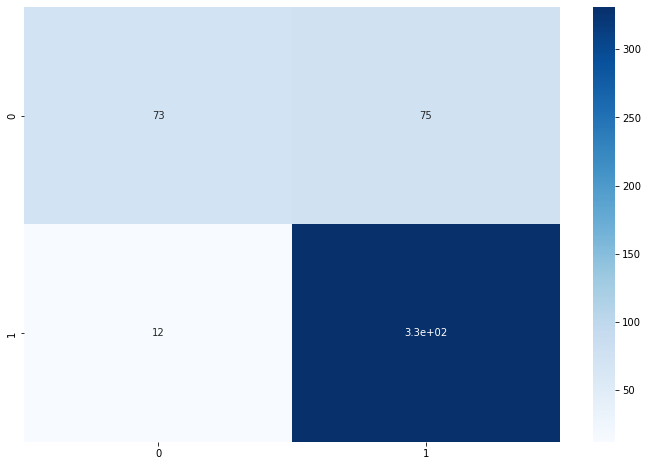

In [124]:
pred = knn_clf.predict(X_train_prep)
plot_cm(y_train_prep, pred)

In [125]:
false_pos_rate(knn_clf, X_train_prep, y_train_prep, cv=10)

FPR - Model: [0.8666666666666667, 0.7333333333333334, 0.6666666666666667, 0.4666666666666667, 0.6, 0.7333333333333334, 0.6, 0.7333333333333334, 0.6428571428571428, 0.5714285714285714]
FPR - Dummy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


60.0% Precision marker: 0.0
Recall at 60.0% Precision: 1.0


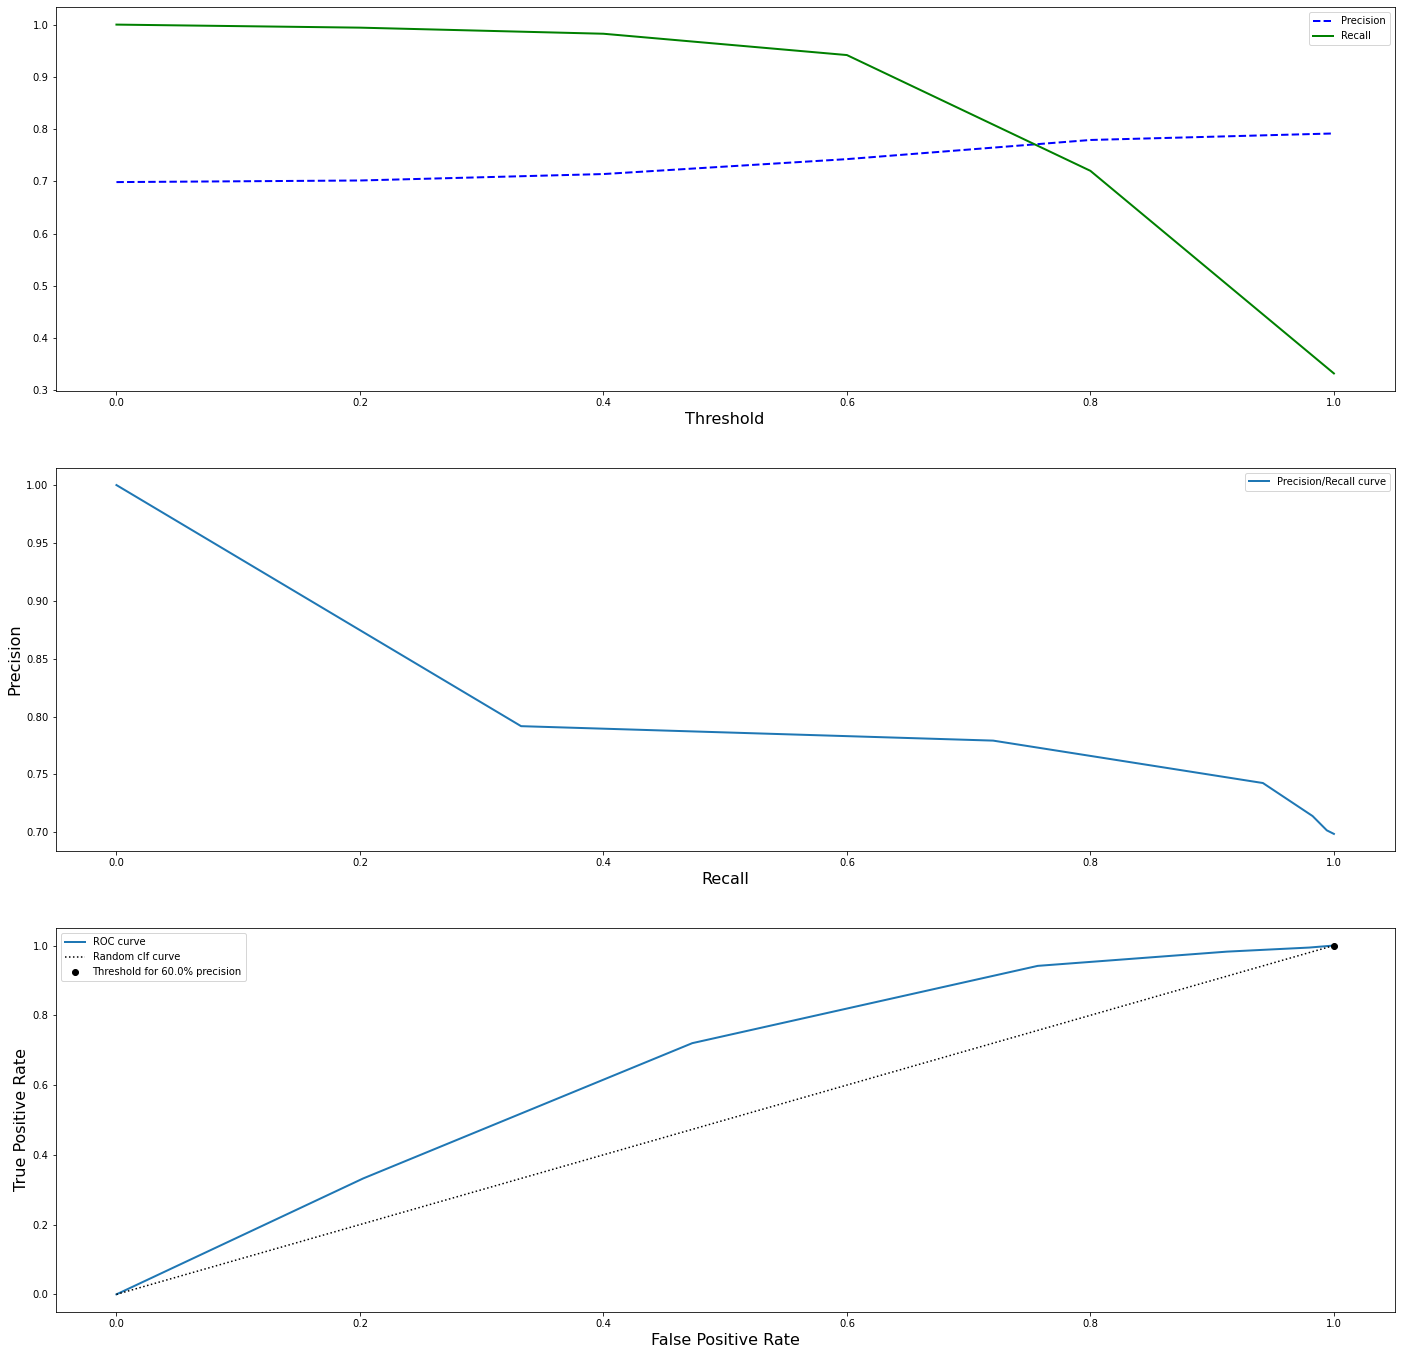

In [126]:
threshold_eval(knn_clf, X_train_prep, y_train_prep, cv=3, method='predict_proba', threshold=0.6)

## AdaBoost

In [130]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = make_pipeline(TotalIncomeFeature(),preprocessing, AdaBoostClassifier())
ada_clf.fit(X_train_prep, y_train_prep)

Pipeline(steps=[('totalincomefeature', TotalIncomeFeature()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('Adjust_distribution',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('function',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function fourth_root at 0x0000025A13568040>)),
                                                                  ('standard',
                                                                   StandardScaler())]),
                                                  ['LoanAmou...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['PropertyArea', 'Dependents',
                                                   'CreditHistory', 'Gender',
                                                   'Married', 'Education',
                                                   'SelfEmployed']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'LoanAmountTerm'])])),
                ('adaboostclassifier', AdaBoostClassifier())])

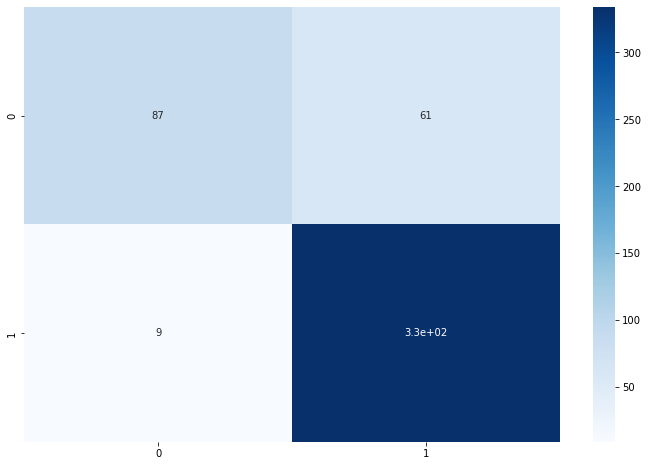

In [131]:
pred = ada_clf.predict(X_train_prep)
plot_cm(y_train_prep, pred)

In [132]:
false_pos_rate(ada_clf, X_train_prep, y_train_prep, cv=10)

FPR - Model: [0.5333333333333333, 0.4666666666666667, 0.6666666666666667, 0.33333333333333337, 0.6, 0.5333333333333333, 0.33333333333333337, 0.8, 0.4285714285714286, 0.4285714285714286]
FPR - Dummy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


90.0% Precision marker: 0.692768843749016
Recall at 90.0% Precision: 0.008746355685131196


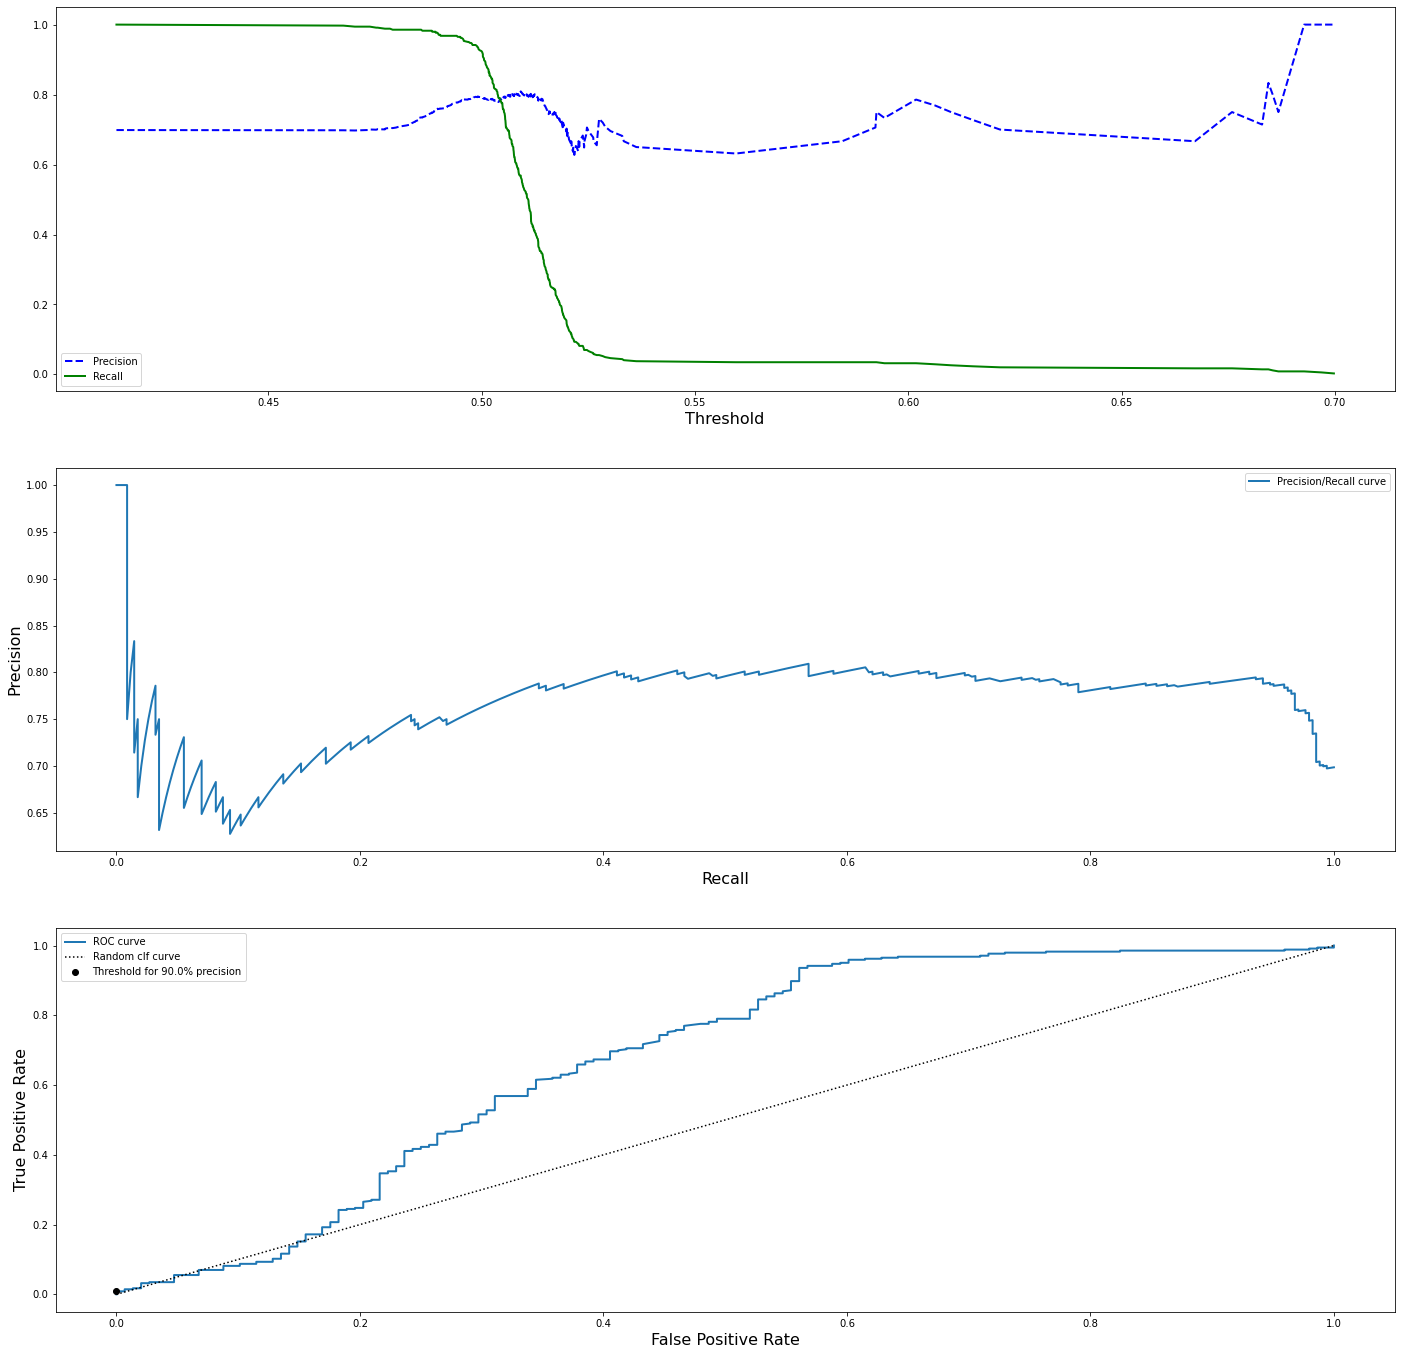

In [133]:
threshold_eval(ada_clf, X_train_prep, y_train_prep, cv=3, method='predict_proba', threshold=0.9)

# Refining Models with Searches

## SGD

In [137]:
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'pca__n_components':[5,7,10],
     'sgdclassifier__loss':['hinge', 'squared_hinge'],
     'sgdclassifier__penalty':['l2', 'elasticnet'],
     'sgdclassifier__class_weight':[{0:1, 1:1}, {0:3, 1:1}, {0:5, 1:1}],
    },
    {'pca__n_components':[0.5,0.8,0.95,1],
    'sgdclassifier__loss':['hinge', 'squared_hinge'],
    'sgdclassifier__penalty':['l2', 'elasticnet'],
    'sgdclassifier__class_weight':[{0:1, 1:1}, {0:3, 1:1}, {0:5, 1:1}],
    }
]
sgd_pipe = make_pipeline(TotalIncomeFeature(), preprocessing, PCA(n_components=0.95), SGDClassifier(random_state=7))
grid_search = GridSearchCV(sgd_pipe, param_grid, cv=3, n_jobs=5, scoring='precision')
grid_search.fit(X_train_prep, y_train_prep)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('totalincomefeature',
                                        TotalIncomeFeature()),
                                       ('columntransformer',
                                        ColumnTransformer(transformers=[('Adjust_distribution',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('function',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<function fourth_root at 0x0000025A13568040>)),
                                                                                         ('standard',
                                                                                          St...
                          'sgdclassifier__class_weight': [{0: 1, 1: 1},
                                                          {0: 3, 1: 1},
                                                          {0: 5, 1: 1}],
                          'sgdclassifier__loss': ['hinge', 'squared_hinge'],
                          'sgdclassifier__penalty': ['l2', 'elasticnet']},
                         {'pca__n_components': [0.5, 0.8, 0.95, 1],
                          'sgdclassifier__class_weight': [{0: 1, 1: 1},
                                                          {0: 3, 1: 1},
                                                          {0: 5, 1: 1}],
                          'sgdclassifier__loss': ['hinge', 'squared_hinge'],
                          'sgdclassifier__penalty': ['l2', 'elasticnet']}],
             scoring='precision')

### Testing

In [139]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_sgdclassifier__class_weight,param_sgdclassifier__loss,param_sgdclassifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
33,0.027000,0.000817,0.014333,0.003300,10,"{0: 5, 1: 1}",hinge,elasticnet,"{'pca__n_components': 10, 'sgdclassifier__clas...",0.826087,0.967742,0.846154,0.879994,0.062585,1
34,0.028668,0.001886,0.014000,0.001412,10,"{0: 5, 1: 1}",squared_hinge,l2,"{'pca__n_components': 10, 'sgdclassifier__clas...",0.791667,0.923077,0.804348,0.839697,0.059185,2
68,0.032334,0.003092,0.016668,0.001245,0.95,"{0: 5, 1: 1}",hinge,l2,"{'pca__n_components': 0.95, 'sgdclassifier__cl...",0.815789,0.928571,0.764706,0.836356,0.068460,3
66,0.033334,0.001698,0.016332,0.000944,0.95,"{0: 3, 1: 1}",squared_hinge,l2,"{'pca__n_components': 0.95, 'sgdclassifier__cl...",0.804348,0.905660,0.794118,0.834709,0.050344,4
70,0.027665,0.000942,0.014001,0.000818,0.95,"{0: 5, 1: 1}",squared_hinge,l2,"{'pca__n_components': 0.95, 'sgdclassifier__cl...",0.811321,0.888889,0.795699,0.831970,0.040750,5


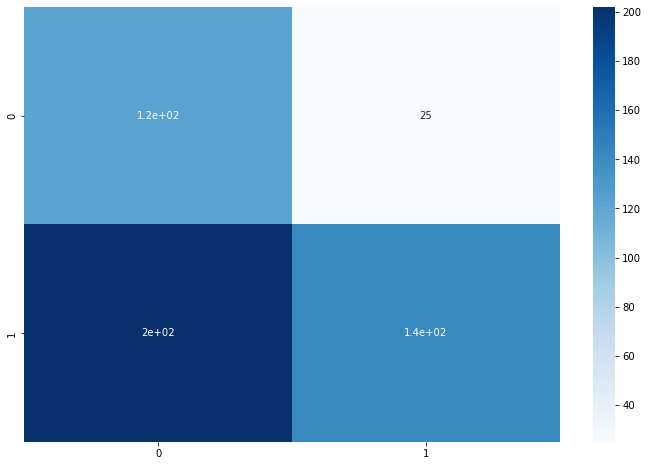

In [140]:
pred = grid_search.best_estimator_.predict(X_train_prep)
plot_cm(y_train_prep, pred)

In [146]:
false_pos_rate(grid_search.best_estimator_, X_train_prep, y_train_prep, cv=3)

FPR - Model: [0.24, 0.020408163265306145, 0.12244897959183676]
FPR - Dummy: [1.0, 1.0, 1.0]


## KNeighbors

In [174]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

knn_pipe = make_pipeline(TotalIncomeFeature(), preprocessing, PCA(), KNeighborsClassifier())
param_dist = [
    {
        'pca__n_components':randint(low=2, high=14),
        'kneighborsclassifier__n_neighbors':randint(low=2, high=20),
        'kneighborsclassifier__metric':['cosine'],
        'kneighborsclassifier__p':randint(low=1, high=20)
    }
]
rnd_knn_search = RandomizedSearchCV(knn_pipe, param_distributions=param_dist, n_iter=20000, cv=3, n_jobs=6, scoring='precision', random_state=7)
rnd_knn_search.fit(X_train_prep, y_train_prep)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('totalincomefeature',
                                              TotalIncomeFeature()),
                                             ('columntransformer',
                                              ColumnTransformer(transformers=[('Adjust_distribution',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('function',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function fourth_root at 0x0000025A13568040>)),
                                                                                               ('standa...
                   param_distributions=[{'kneighborsclassifier__metric': ['cosine'],
                                         'kneighborsclassifier__n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025A1683A590>,
                                         'kneighborsclassifier__p': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025A19854C70>,
                                         'pca__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025A19901750>}],
                   random_state=7, scoring='precision')

In [175]:
pd.DataFrame(rnd_knn_search.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__metric,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__p,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12230,0.028669,0.000944,0.022998,0.000815,cosine,2,11,12,"{'kneighborsclassifier__metric': 'cosine', 'kn...",0.8125,0.802198,0.846154,0.820284,0.01877,1
13059,0.031002,0.000816,0.028332,0.001244,cosine,2,16,12,"{'kneighborsclassifier__metric': 'cosine', 'kn...",0.8125,0.802198,0.846154,0.820284,0.01877,1
10083,0.037335,0.001245,0.028665,0.002357,cosine,2,7,12,"{'kneighborsclassifier__metric': 'cosine', 'kn...",0.8125,0.802198,0.846154,0.820284,0.01877,1
2487,0.031704,0.001832,0.024666,0.002494,cosine,2,7,12,"{'kneighborsclassifier__metric': 'cosine', 'kn...",0.8125,0.802198,0.846154,0.820284,0.01877,1
4190,0.030334,0.002358,0.023333,0.001701,cosine,2,6,12,"{'kneighborsclassifier__metric': 'cosine', 'kn...",0.8125,0.802198,0.846154,0.820284,0.01877,1


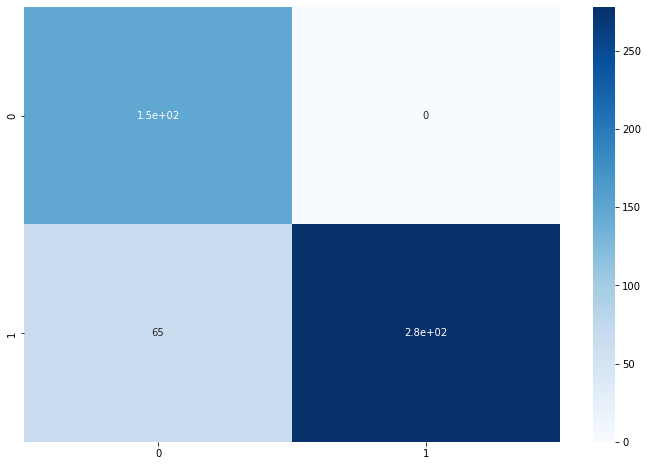

In [176]:
pred = rnd_knn_search.best_estimator_.predict(X_train_prep)
plot_cm(y_train_prep, pred)

In [177]:
false_pos_rate(rnd_knn_search.best_estimator_, X_train_prep, y_train_prep, cv=5)

FPR - Model: [0.3666666666666667, 0.3666666666666667, 0.43333333333333335, 0.3793103448275862, 0.2068965517241379]
FPR - Dummy: [1.0, 1.0, 1.0, 1.0, 1.0]


## AdaBoost

In [201]:
ada_pipe = make_pipeline(TotalIncomeFeature(), preprocessing, PCA(), AdaBoostClassifier())
param_dist = [
    {
        'pca__n_components':randint(low=2, high=14),
        'adaboostclassifier__n_estimators':randint(low=25, high=250),
        'adaboostclassifier__learning_rate':np.random.uniform(low=0.25, high=5, size=1),
        'adaboostclassifier__random_state':[7]
    }
]

rnd_ada_search = RandomizedSearchCV(ada_pipe, param_distributions=param_dist, n_iter=20000, cv=3, n_jobs=6,
                                    scoring='precision', random_state=7)
rnd_ada_search.fit(X_train_prep, y_train_prep)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('totalincomefeature',
                                              TotalIncomeFeature()),
                                             ('columntransformer',
                                              ColumnTransformer(transformers=[('Adjust_distribution',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('function',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function fourth_root at 0x0000025A13568040>)),
                                                                                               ('standa...
                   param_distributions=[{'adaboostclassifier__learning_rate': array([3.40941217]),
                                         'adaboostclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025A19BFB7C0>,
                                         'adaboostclassifier__random_state': [7],
                                         'pca__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025A1985EDD0>}],
                   random_state=7, scoring='precision')

In [202]:
pd.DataFrame(rnd_ada_search.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_adaboostclassifier__learning_rate,param_adaboostclassifier__n_estimators,param_adaboostclassifier__random_state,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12184,0.121704,0.008178,0.027665,0.001888,3.409412,56,7,3,{'adaboostclassifier__learning_rate': 3.409412...,0.5,1.0,1.0,0.833333,0.235702,1
7961,0.327332,0.003093,0.051332,0.001246,3.409412,178,7,3,{'adaboostclassifier__learning_rate': 3.409412...,0.5,1.0,1.0,0.833333,0.235702,1
12352,0.346997,0.006537,0.054348,0.003312,3.409412,200,7,3,{'adaboostclassifier__learning_rate': 3.409412...,0.5,1.0,1.0,0.833333,0.235702,1
13675,0.215664,0.006601,0.036333,0.002053,3.409412,96,7,5,{'adaboostclassifier__learning_rate': 3.409412...,0.5,1.0,1.0,0.833333,0.235702,1
7964,0.142663,0.006018,0.030668,0.000471,3.409412,60,7,3,{'adaboostclassifier__learning_rate': 3.409412...,0.5,1.0,1.0,0.833333,0.235702,1


FPR - Model: [0.040000000000000036, 0.0, 0.0]
FPR - Dummy: [1.0, 1.0, 1.0]


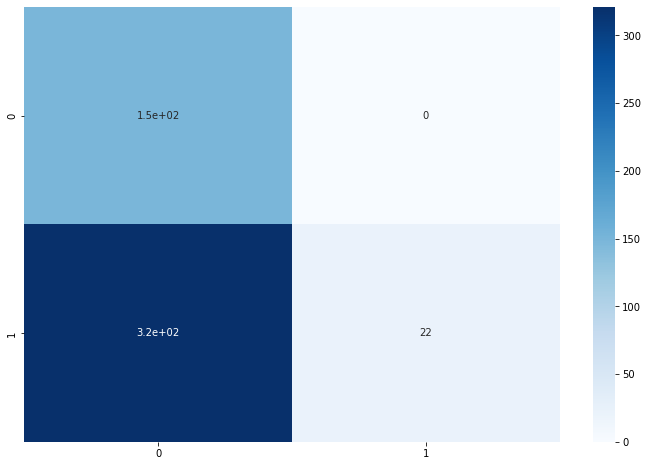

In [203]:
false_pos_rate(rnd_ada_search.best_estimator_, X_train_prep, y_train_prep, cv=3)
pred = rnd_ada_search.best_estimator_.predict(X_train_prep)
plot_cm(y_train_prep, pred)

## Takeaway
Given the small dataset, simple models perform well. Powerful ensemble methods have overfitting issues on such a small dataset. Even regularization is unable to properly train despite shuffle splitting.

# Stacking

In [204]:
import joblib
joblib.dump(grid_search.best_estimator_, 'sgd_clf.pkl')
joblib.dump(rnd_ada_search.best_estimator_, 'ada_clf.pkl')
joblib.dump(rnd_knn_search.best_estimator_, 'knn_clf.pkl')

['knn_clf.pkl']

In [195]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
stack_clf = StackingClassifier(
    estimators = [
        ('sgdclassifier', grid_search.best_estimator_),
        ('adaboostclassifier', rnd_ada_search.best_estimator_),
        ('kneighborsclassifier', rnd_knn_search.best_estimator_),
        
    ],
    final_estimator=LogisticRegression(class_weight={0:1, 1:1}, random_state=7),
    stack_method='auto',
    cv=5,
    n_jobs=6
)
stack_clf.fit(X_train_prep, y_train_prep)

StackingClassifier(cv=5,
                   estimators=[('sgdclassifier',
                                Pipeline(steps=[('totalincomefeature',
                                                 TotalIncomeFeature()),
                                                ('columntransformer',
                                                 ColumnTransformer(transformers=[('Adjust_distribution',
                                                                                  Pipeline(steps=[('impute',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('function',
                                                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                       func=<function fourth_root at 0x0000025A1...
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('standardscaler',
                                                                                                   StandardScaler())]),
                                                                                  ['ApplicantIncome',
                                                                                   'CoapplicantIncome',
                                                                                   'LoanAmount',
                                                                                   'LoanAmountTerm'])])),
                                                ('pca', PCA(n_components=12)),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier(metric='cosine',
                                                                      n_neighbors=2,
                                                                      p=14))]))],
                   final_estimator=LogisticRegression(class_weight={0: 1, 1: 1},
                                                      random_state=7),
                   n_jobs=6)

FPR - Model: [0.78, 0.6734693877551021, 0.7142857142857143]
FPR - Dummy: [1.0, 1.0, 1.0]


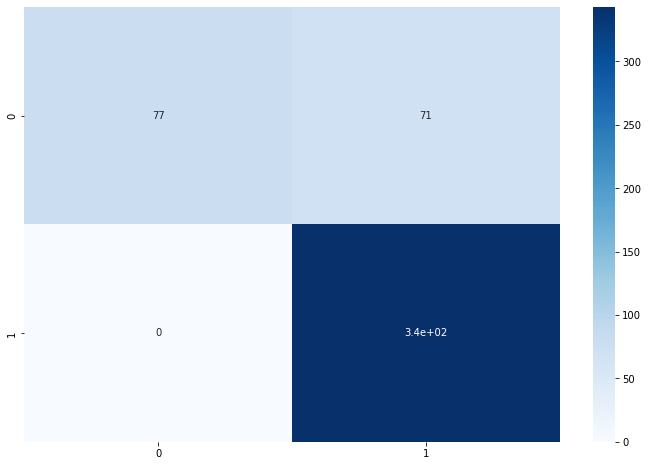

In [196]:
false_pos_rate(stack_clf, X_train_prep, y_train_prep, cv=3)
stack_pred = stack_clf.predict(X_train_prep)
plot_cm(y_train_prep, stack_pred)

## VotingClassifier

In [197]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators = [
        ('sgdclassifier', grid_search.best_estimator_),
        ('kneighborsclassifier', rnd_knn_search.best_estimator_),
        ('adaboostclassifier', rnd_ada_search.best_estimator_),
    ],
    voting='hard',
    # weights=[2,1,1],
    n_jobs=5
)
voting_clf.fit(X_train_prep, y_train_prep)

VotingClassifier(estimators=[('sgdclassifier',
                              Pipeline(steps=[('totalincomefeature',
                                               TotalIncomeFeature()),
                                              ('columntransformer',
                                               ColumnTransformer(transformers=[('Adjust_distribution',
                                                                                Pipeline(steps=[('impute',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('function',
                                                                                                 FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                     func=<function fourth_root at 0x0000025A13568040...
                                                                                 'SelfEmployed']),
                                                                               ('num',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('standardscaler',
                                                                                                 StandardScaler())]),
                                                                                ['ApplicantIncome',
                                                                                 'CoapplicantIncome',
                                                                                 'LoanAmount',
                                                                                 'LoanAmountTerm'])])),
                                              ('pca', PCA(n_components=12)),
                                              ('adaboostclassifier',
                                               AdaBoostClassifier(learning_rate=0.4598869624431104,
                                                                  n_estimators=74,
                                                                  random_state=7))]))],
                 n_jobs=5)

FPR - Model: [0.36, 0.326530612244898, 0.26530612244897955]
FPR - Dummy: [1.0, 1.0, 1.0]


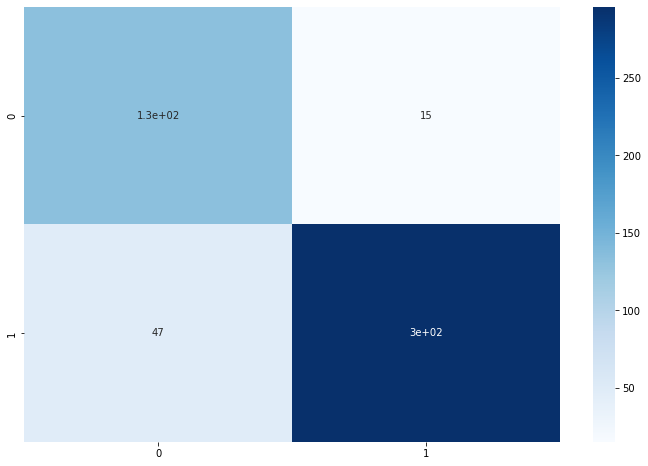

In [198]:
false_pos_rate(voting_clf, X_train_prep, y_train_prep, cv=3)
vote_pred = voting_clf.predict(X_train_prep)
plot_cm(y_train_prep, vote_pred)

# Final Testing

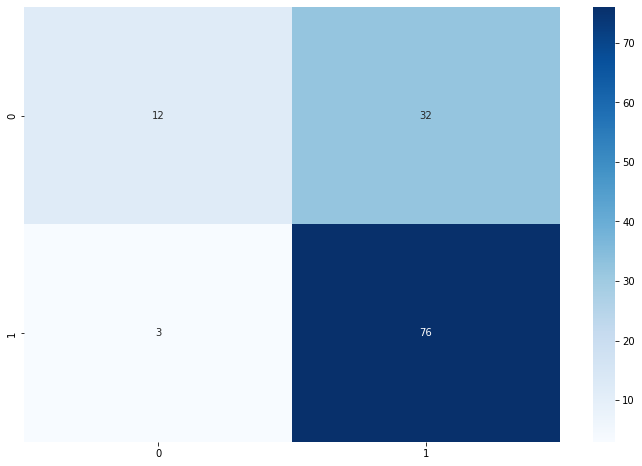

In [199]:
X_test = strat_test.iloc[:, :-1]
y_test = strat_test.iloc[:, -1]
X_test.drop(['LoanID'], axis=1, inplace=True)
pred = stack_clf.predict(X_test)
y_test = lb.fit_transform(y_test)
y_test_prep = y_test.ravel()
plot_cm(y_test_prep, pred)

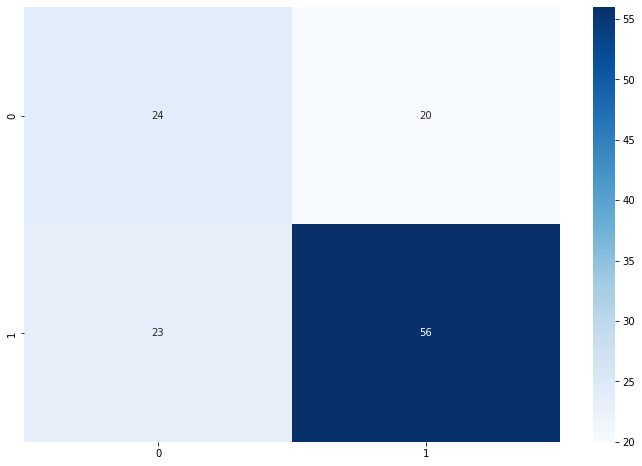

In [200]:
X_test = strat_test.iloc[:, :-1]
y_test = strat_test.iloc[:, -1]
X_test.drop(['LoanID'], axis=1, inplace=True)
pred = voting_clf.predict(X_test)
y_test = lb.fit_transform(y_test)
y_test_prep = y_test.ravel()
plot_cm(y_test_prep, pred)